# Machine Learning with Turbulent Simulations

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os
import re


# import ImportData


In [125]:
folder = os.getcwd()+'/OpenFOAMfiles/turbulent/machineRANS/0.2'
# folder = os.getcwd()+'/OpenFOAMfiles/laminar/0.1'
def ImportData(folder):
    file_list = []
    file_list.append(pd.read_table('./Mesh/meshcoord.txt',sep="\s+"))
    for filename in os.listdir(folder):
        if filename.endswith(".txt"): 
            file_list.append(pd.read_csv(os.path.join(folder, filename),sep="\s+"))
    df = pd.DataFrame()
    df = pd.concat(file_list,axis=1)
    df = df.drop(['vz','v','ccz'],axis=1)
    variables = {}
    for col in df.columns:
        variables[col],ccx,ccy = np.histogram2d(df.ccx,df.ccy,weights=df[col],bins=(225,200))
        variables[col] = np.vstack((np.zeros(200),variables[col],np.zeros(200)))
        variables[col] = np.hstack((np.zeros((227,1)),variables[col],np.zeros((227,1))))
        variables[col] = variables[col].T[::-1]
        
    o = np.zeros((225,200))
    xg, yg = np.meshgrid(np.arange(100,125,1),np.arange(0,50,1))
    for i in np.arange(100,125,1):
        for j in np.arange(0,50,1):
            o[i,j] = 1
    variables['o'] = o
    variables['o'] = np.vstack((np.ones(200)+5,variables['o'],np.ones(200)+2))
    variables['o'] = np.hstack((np.ones((227,1)),variables['o'],np.ones((227,1))))
    variables['o'] = variables['o'].T[::-1]
    
    dataconv = variables.copy()
    
    variables.pop('ccx',None)
    variables.pop('ccy',None)
    
    plist = []
    for i in np.arange(1,201,1):
        for j in np.arange(1,226,1):
            di = {}
            for col in variables:
                di.update({col+'in':variables[col][i,j],col+'right':variables[col][i,j-1],
                              col+'left':variables[col][i,j+1],col+'up':variables[col][i-1,j],
                              col+'down':variables[col][i+1,j]})
                di.update({'ccx':ccx[j-1],'ccy':ccy[-i]})
            plist.append(di)
    data= pd.DataFrame(plist)
    
    return data,dataconv
data,dataconv = ImportData(folder)

In [126]:
data.head()

ccx   ccy  epsilondown  epsilonin  epsilonleft  epsilonright  \
0  0.010000  3.99     12.98850     9.5403       9.8719        0.0000   
1  0.029911  3.99     11.44360     9.8719      10.1973        9.5403   
2  0.049822  3.99     10.15950    10.1973      10.5160        9.8719   
3  0.069733  3.99      9.08362    10.5160      10.8275       10.1973   
4  0.089644  3.99      8.17571    10.8275      11.1317       10.5160   

   epsilonup     kdown       kin     kleft  ...    vxdown     vxin   vxleft  \
0        0.0  0.349395  0.384099  0.392948  ...   10.0038  9.99068  9.97375   
1        0.0  0.327062  0.392948  0.401537  ...   10.0173  9.97375  9.95370   
2        0.0  0.307558  0.401537  0.409859  ...   10.0328  9.95370  9.93000   
3        0.0  0.290440  0.409859  0.417914  ...   10.0477  9.93000  9.90497   
4        0.0  0.275350  0.417914  0.425705  ...   10.0622  9.90497  9.88018   

   vxright  vxup    vydown      vyin    vyleft   vyright  vyup  
0  0.00000   0.0 -0.004608 -0.019997 -0.031622  0.000000   0.0  
1  9.99068   0.0 -0.009767 -0.031622 -0.034902 -0.019997   0.0  
2  9.97375   0.0 -0.011445 -0.034902 -0.036027 -0.031622   0.0  
3  9.95370   0.0 -0.011961 -0.036027 -0.036660 -0.034902   0.0  
4  9.93000   0.0 -0.012314 -0.036660 -0.036992 -0.036027   0.0  

[5 rows x 37 columns]

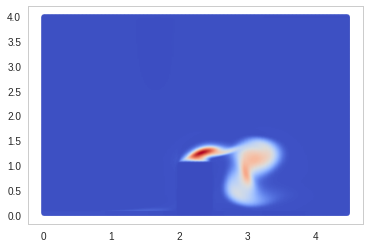

In [129]:
plt.scatter(data.ccx,data.ccy,c=data.nutin,s=20.,cmap='coolwarm')